# **Modelo Matemático da Programação Dinâmica (PD) para o Problema ULS**

## **1. Formulação do Problema**

### **Parâmetros:**
- $n$: número de períodos
- $k$: período final considerado (recursão)  
- $d_t$: demanda no período $t$ ($t = 1, \ldots, n$)  
- $f_t$: custo fixo de setup no período $t$  
- $c_t$: custo variável de produção no período $t$  
- $h_t$: custo de estoque por unidade no período $t$  
 OBS: $k$ também pode significar o último período do problema, então $k$=$n$.

### **Variáveis de Decisão:**
- $x_t$: quantidade produzida no período $t$  
- $s_t$: estoque no final do período $t$  
- $y_t$: variável binária indicando produção no período $t$ ($y_t=1$ se $x_t > 0$, $y_t=0$ caso contrário)

* * *

## **2. Formulação de Programação Dinâmica (Wagner-Whitin)**

### **2.1 Definições Fundamentais**

**Demanda Acumulada:**\
$$
S_k = \sum_{t=1}^{k} d_t \quad \text{para } k = 0, 1, \ldots, n \quad \text{com } S_0 = 0
$$

**Função de Custo Mínimo:**\
$$
F(k) = \text{custo mínimo para atender as demandas dos primeiros } k \text{ períodos}
$$

**Condição Inicial:**\
$$
F(0) = 0
$$

* * *

### **2.2 Recursão Principal**

Para $k = 1, 2, \ldots, n$:\
$$
F(k) = \min_{0 \leq j < k} \left\{ F(j) + C(j+1, k) \right\}
$$

Onde $C(j+1, k)$ é o custo de **produzir no período $j+1$** para atender as demandas dos períodos $j+1$ até $k$:

$$
C(j+1, k) = f_{j+1} + c_{j+1} \cdot (S_k - S_j) + \sum_{t=j+1}^{k-1} h_t \cdot (S_k - S_t)
$$

E $F(j)$ é o menor custo possível para satisfazer toda a demanda acumulando até o período $j$.

OBS: O $F(j)$ ele "guarda a melhor solução até o período $j$, sem olhar ainda o que vem depois. Ele é quem é utilizado quando a recursão $F(k)$ é caalculada.
* * *

### **2.3 Decomposição do Custo $C(j+1, k)$**

**1. Custo Fixo de Setup:**\
$$f_{j+1}$$

**2. Custo Variável de Produção:**\
$$c_{j+1} \cdot (S_k - S_j) = c_{j+1} \cdot \sum_{t=j+1}^{k} d_t$$

**3. Custo de Estoque:**\
$$\sum_{t=j+1}^{k-1} h_t \cdot (S_k - S_t) = \sum_{t=j+1}^{k-1} h_t \cdot \sum_{m=t+1}^{k} d_m$$

* * *

### **2.4 Interpretação do Custo de Estoque**

O termo $h_t \cdot (S_k - S_t)$ representa:  
- $S_k - S_t = d_{t+1} + d_{t+2} + \cdots + d_k$: demanda total dos períodos futuros  
- Cada unidade demandada no período $m$ ($m > t$) fica em estoque durante os períodos $t, t+1, \ldots, m-1$  
- O custo acumulado por unidade é $h_t + h_{t+1} + \cdots + h_{m-1}$  

* * *

## **3. Formulação Matemática Completa**

### **3.1 Função Objetivo da PD**
$$
F(k) = \min_{0 \leq j < k} \left\{ F(j) + f_{j+1} + c_{j+1}(S_k - S_j) + \sum_{t=j+1}^{k-1} h_t(S_k - S_t) \right\}
$$

### **3.2 Restrições Implícitas**
1. **Conservação de estoque**: A produção em $j+1$ deve atender toda a demanda de $j+1$ até $k$  
2. **Estoque final zero**: $s_n = 0$ (garantido pela estrutura da PD)  
3. **Não-negatividade**: $x_t \geq 0, s_t \geq 0$ (implícito na formulação)  

* * *

## **4. Relação com a Formulação MIP**

A programação dinâmica **resolve exatamente o mesmo problema** que a formulação MIP padrão para o ULS.

### **Formulação MIP Padrão**

**Função Objetivo:**
$$
\text{Minimizar } \sum_{t=1}^{n} (p_t x_t + h_t s_t + f_t y_t)
$$

**Sujeito a:**
1. **Balanço de Estoque:** Para $t = 1, \ldots, n$:
   $$
   s_{t-1} + x_t = d_t + s_t \quad \text{com } s_0 = 0
   $$
2. **Restrição de Produção/Setup (Big M):** Para $t = 1, \ldots, n$:
   $$
   x_t \leq M y_t \quad \text{onde M é um limite superior grande para } x_t \text{ (ex: demanda total acumulada)}
   $$
3. **Não-negatividade:** Para $t = 1, \ldots, n$:
   $$
   x_t \geq 0
   $$
   $$
   s_t \geq 0
   $$
4. **Binariedade:** Para $t = 1, \ldots, n$:
   $$
   y_t \in \{0, 1\}
   $$

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os, time, re
import numpy as np
import pandas as pd # importar pandas para salvar resultados

# configuração dos caminhos
folder_path = "/home/jossian/repository/mmq_msc_andressa/data/uls/"
result_path = "result"
os.makedirs(result_path, exist_ok=True)

In [9]:
#ordem das linhas do arquivo
#N = Número de períodos
#H = Custo de setup (para cada periodo)
#P = Custo de produção (para cada período)
#F = Custo de estoque (para cada período)
#D = Vetor contendo as demandas

In [10]:
def readdata(datafile):
    """Lê os dados"""
    path = os.path.join(folder_path, datafile)
    with open(path, 'r') as file:
        linhas = file.readlines()

    # remove linha vazia inicial e elimina os "\n" de cada linha
    linhas = [a.strip() for a in linhas if a.strip() != ""]

    # lendo o tamanho da instancia
    N = int(float(linhas[0]))  # primeira linha é o número de períodos

    # definindo vetores
    H = np.zeros(N)
    P = np.zeros(N)
    F = np.zeros(N)
    D = np.zeros(N)

    # lendo e armazenando dados (mesma lógica do seu código)
    F[0] = float(linhas[1])
    for i in range(1, N):
        F[i] = F[0]

    H[0] = float(linhas[2])
    for i in range(1, N):
        H[i] = H[0]

    P[0] = float(linhas[3])
    for i in range(1, N):
        P[i] = P[0]

    # lendo demandas
    demandas = linhas[4].split()
    for i in range(min(N, len(demandas))):
        D[i] = float(demandas[i])

    return N, H, P, F, D

In [11]:
def solve_uls_dynamic_simple(N, H, P, F, D):
    """
    Programação dinâmica
    Baseada na formulação de Wagner-Whitin
    """
    # pré-calcular demandas acumuladas
    S = np.zeros(N + 1)
    for i in range(1, N + 1):
        S[i] = S[i - 1] + D[i - 1]

    # F[k] = custo mínimo para os primeiros k períodos
    F_dp = np.full(N + 1, np.inf)
    pred = np.full(N + 1, -1, dtype=int)
    F_dp[0] = 0.0

    for k in range(1, N + 1):
        for j in range(0, k):  # j = 0, 1, ..., k-1
            # qroduzir no período j+1 para atender j+1 até k
            t = j + 1

            # quantidade a produzir
            quantity = S[k] - S[j]

            # custo de produção
            production_cost = F[t-1] + P[t-1] * quantity

            # custo de estoque
            # para cada período m de t+1 até k, a demanda D[m-1] fica em estoque
            # desde o período t até m-1
            holding_cost = 0.0
            current_inventory = 0.0

            # simular o acúmulo de estoque período a período
            inventory = 0.0
            for period in range(t, k + 1):
                if period == t:
                    # no período de produção, adiciona a quantidade produzida
                    inventory += quantity

                # subtrai a demanda do período
                inventory -= D[period - 1]

                # adiciona custo de estoque se inventory > 0
                if period < k:  # estoque no final do período
                    holding_cost += H[period - 1] * inventory


            total_cost = F_dp[j] + production_cost + holding_cost

            if total_cost < F_dp[k]:
                F_dp[k] = total_cost
                pred[k] = t

    return F_dp[N], F_dp, pred, S

In [12]:
def recover_plan(pred, S, D, N):
    """Recupera o plano de produção"""
    x = np.zeros(N)
    y = np.zeros(N)

    k = N
    production_periods = []

    while k > 0:
        t = pred[k]
        production_periods.append(t)
        x[t-1] = S[k] - S[t-1]
        y[t-1] = 1
        k = t - 1

    # calcular estoques
    s = np.zeros(N)
    current_inv = 0.0
    for i in range(N):
        current_inv += x[i] - D[i]
        s[i] = current_inv


    return x, y, s

In [16]:
def main_dynamic(datafile):
    """Função principal da programação dinâmica"""
    try:
        # ler dados
        N, H, P, F, D = readdata(datafile)

        print(f"\n--- Processando Instância: {datafile} ---")
        # print(f"Períodos: {N}")
        # print(f"F = {F[0]}, P = {P[0]}, H = {H[0]}")
        # print(f"Demanda total: {sum(D):.0f}")

        # resolver via PD
        start_time = time.time()
        objval, F_dp, pred, S = solve_uls_dynamic_simple(N, H, P, F, D)
        end_time = time.time()
        exec_time = end_time - start_time

        # recuperar plano (opcional para o resumo, mas útil para debug)
        # x, y, s = recover_plan(pred, S, D, N)


        print(f"  Custo ótimo calculado pela PD: {objval:.2f}")
        print(f"  Tempo de execução da PD: {exec_time:.4f}s")

        # mostrar plano (removido para não poluir a saída com muitas instâncias)
        # print("\nPlano de produção:")
        # for i in range(N):
        #     if x[i] > 0.001:
        #         print(f"  Período {i+1}: produzir {x[i]:.1f}, estoque final: {s[i]:.1f}")

        return datafile, objval, exec_time

    except Exception as e:
        print(f"Erro ao processar {datafile}: {e}")
        return datafile, None, None, None, None, None, float('inf'), float('inf')


In [17]:
# execução principal
if __name__ == "__main__":
    print("=" * 60)
    print("PROGRAMAÇÃO DINÂMICA - ULS (Processando todas as instâncias)")
    print("=" * 60)

    results = []
    total_time = 0
    time_limit = 60 # limite de tempo em segundos

    # listar todos os arquivos .txt na pasta de instâncias
    instance_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    instance_files.sort() # processar em ordem alfabética

    for datafile in instance_files:
        if total_time < time_limit:
            file_path = os.path.join(folder_path, datafile)
            if os.path.isfile(file_path): # garantir que é um arquivo
                file_result = main_dynamic(datafile)
                results.append(file_result)
                total_time += file_result[-1] if file_result[-1] != float('inf') else 0 # adiciona tempo se não for erro
        else:
            print(f"\nLimite de tempo ({time_limit}s) atingido. Interrompendo processamento.")
            break

    # criar um DataFrame com os resultados
    results_df = pd.DataFrame(results, columns=['instance', 'optimal', 'time'])


PROGRAMAÇÃO DINÂMICA - ULS (Processando todas as instâncias)

--- Processando Instância: 52_1.txt ---
  Custo ótimo calculado pela PD: 9269.20
  Tempo de execução da PD: 0.0093s

--- Processando Instância: 52_10.txt ---
  Custo ótimo calculado pela PD: 12408.00
  Tempo de execução da PD: 0.0091s

--- Processando Instância: 52_2.txt ---
  Custo ótimo calculado pela PD: 9263.40
  Tempo de execução da PD: 0.0100s

--- Processando Instância: 52_3.txt ---
  Custo ótimo calculado pela PD: 9179.20
  Tempo de execução da PD: 0.0095s

--- Processando Instância: 52_4.txt ---
  Custo ótimo calculado pela PD: 9687.00
  Tempo de execução da PD: 0.0108s

--- Processando Instância: 52_5.txt ---
  Custo ótimo calculado pela PD: 11292.00
  Tempo de execução da PD: 0.0111s

--- Processando Instância: 52_6.txt ---
  Custo ótimo calculado pela PD: 11347.50
  Tempo de execução da PD: 0.0232s

--- Processando Instância: 52_7.txt ---
  Custo ótimo calculado pela PD: 11157.00
  Tempo de execução da PD: 0.0112

In [19]:
    # salvar os resultados em um arquivo CSV
    results_csv_path = os.path.join(result_path, "uls_dynamic_summary.csv")
    results_df.to_csv(results_csv_path, index=False)

    print("\n" + "=" * 60)
    print("RESUMO DOS RESULTADOS")
    print("=" * 60)

    # Ordenar o DataFrame por 'Instância' usando uma chave personalizada para ordenar numericamente após o prefixo
    results_df_sorted = results_df.copy()
    results_df_sorted['sort_key'] = results_df_sorted['instance'].apply(lambda x: int(x.split('_')[1].split('.')[0]))
    results_df_sorted = results_df_sorted.sort_values(by='sort_key').drop('sort_key', axis=1)

    display(results_df_sorted) # Exibir o DataFrame ordenado
    print(f"\nResultados salvos em: {results_csv_path}")
    print(f"Tempo total de execução: {total_time:.4f}s")


RESUMO DOS RESULTADOS


,instance,optimal,time
0,52_1.txt,9269.2,0.009346
2,52_2.txt,9263.4,0.010035
3,52_3.txt,9179.2,0.009453
4,52_4.txt,9687.0,0.010756
5,52_5.txt,11292.0,0.011138
6,52_6.txt,11347.5,0.023171
7,52_7.txt,11157.0,0.011166
8,52_8.txt,11223.0,0.013489
9,52_9.txt,12575.8,0.009363
1,52_10.txt,12408.0,0.009093



Resultados salvos em: result/uls_dynamic_summary.csv
Tempo total de execução: 0.1170s


/tmp/ipykernel_179201/1722617585.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df_sorted, x='instance', y='optimal', ax=ax1, palette='viridis')
/tmp/ipykernel_179201/1722617585.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(results_df_sorted['instance'], rotation=45, ha='right') # definir rótulos do eixo X


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

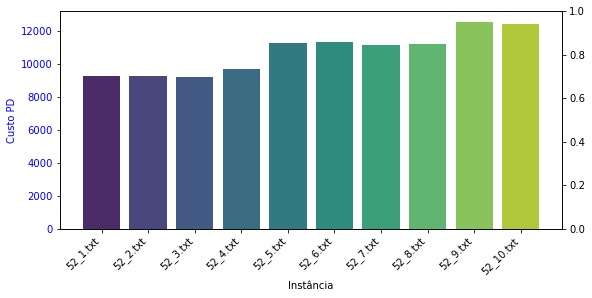

In [31]:
# criar o gráfico com dois eixos Y
import matplotlib.pyplot as plt
import seaborn as sns

# Ordenar o DataFrame por 'Instância' usando uma chave personalizada para ordenar numericamente após o prefixo
results_df_sorted = results_df.copy()
results_df_sorted['sort_key'] = results_df_sorted['instance'].apply(lambda x: int(x.split('_')[1].split('.')[0]))
results_df_sorted = results_df_sorted.sort_values(by='sort_key').drop('sort_key', axis=1)


fig, ax1 = plt.subplots(figsize=(9, 4))

# gráfico de barras para o Custo PD no eixo Y primário
sns.barplot(data=results_df_sorted, x='instance', y='optimal', ax=ax1, palette='viridis')
ax1.set_xlabel('Instância')
ax1.set_ylabel('Custo PD', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(results_df_sorted['instance'], rotation=45, ha='right') # definir rótulos do eixo X

# criar o segundo eixo Y para o Tempo PD
ax2 = ax1.twinx()
sns.lineplot(data=results_df_sorted, x='instance', y='time', ax=ax2, color='red', marker='o', label='Tempo PD (s)')
ax2.set_ylabel('Tempo PD (s)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# adicionar título e legendas
plt.title('Custo e Tempo de Execução da PD por Instância')
fig.tight_layout() # Ajusta o layout para evitar sobreposição

# mostrar o gráfico
plt.show()

In [23]:
print(f"O somatório do tempo de execução total é: {total_time:.2f}s")

O somatório do tempo de execução total é: 0.12s
